In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, he_uniform, lecun_uniform
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier  # Import from scikeras

In [20]:
# Step 1: Define the model creation function
def create_model(initializer='lecun_uniform', learning_rate=0.001, lamda=0.001, num_unit=128, activation='relu'):
    model = Sequential()

    # Use the Input layer explicitly as the first layer
    model.add(Input(shape=(28, 28)))  # Input layer with a specific shape

    # Add Flatten layer and other layers
    model.add(Flatten())
    model.add(Dense(num_unit, activation=activation, kernel_initializer=initializer, 
                    kernel_regularizer=l2(lamda)))

    # Output Layer for classification (assuming 10 classes like MNIST)
    model.add(Dense(10, activation='softmax'))

    # Compile the model with dynamic learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [21]:
# Step 2: Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, verbose=0)

In [22]:
# Step 3: Define the hyperparameter grid
param_grid = {
    'batch_size': [20, 50, 100][:1],
    'epochs': [1, 20, 50][:1],
    'model__initializer': ['lecun_uniform', 'normal', 'he_normal', 'he_uniform'][:1],
    'model__learning_rate': [0.1, 0.001, 0.02][:1],
    'model__lamda': [0.001, 0.005, 0.01][:1],
    'model__num_unit': [256, 128][:1],
    'model__activation': ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'][:1]
}

In [23]:
# Step 4: Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

In [24]:
# Step 5: Load the dataset (we'll use the MNIST dataset here)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [25]:
# Step 6: Fit the GridSearchCV with the training data
grid_result = grid.fit(X_train, y_train)

In [26]:
# Step 7: Output the best hyperparameters and results
print("Best Hyperparameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

Best Hyperparameters:  {'batch_size': 20, 'epochs': 1, 'model__activation': 'relu', 'model__initializer': 'lecun_uniform', 'model__lamda': 0.001, 'model__learning_rate': 0.1, 'model__num_unit': 256}
Best Accuracy:  0.10543333333333334


Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 892us/step - accuracy: 0.8830 - loss: 0.4997
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 893us/step - accuracy: 0.9579 - loss: 0.2342
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.9648 - loss: 0.2043
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - accuracy: 0.9664 - loss: 0.1934
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.9693 - loss: 0.1830


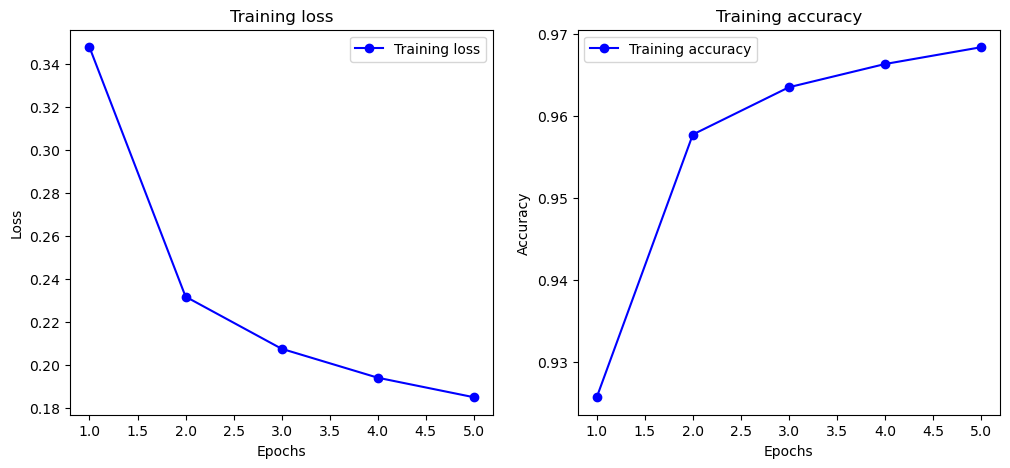

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, he_uniform, lecun_uniform
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt

# Step 1: Define the model creation function
def create_model(initializer='lecun_uniform', learning_rate=0.001, lamda=0.001, num_unit=128, activation='relu'):
    model = Sequential()

    # Use the Input layer explicitly as the first layer
    model.add(Input(shape=(28, 28)))  # Input layer with a specific shape

    # Add Flatten layer and other layers
    model.add(Flatten())
    model.add(Dense(num_unit, activation=activation, kernel_initializer=initializer, 
                    kernel_regularizer=l2(lamda)))

    # Output Layer for classification (assuming 10 classes like MNIST)
    model.add(Dense(10, activation='softmax'))

    # Compile the model with dynamic learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Step 2: Wrap the model using KerasClassifier and capture history
class CustomKerasClassifier(KerasClassifier):
    def fit(self, X, y, **kwargs):
        history = super().fit(X, y, **kwargs)
        self.history_ = history.history_  # Store the history
        return history

# Step 3: Define the hyperparameter grid
param_grid = {
    'batch_size': [20],
    'epochs': [5],  # Keep epochs low for quick training
    'model__initializer': ['lecun_uniform'],
    'model__learning_rate': [0.001],
    'model__lamda': [0.001],
    'model__num_unit': [128],
    'model__activation': ['relu']
}

# Step 4: Create the GridSearchCV object
model = CustomKerasClassifier(model=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Step 5: Load the dataset (we'll use the MNIST dataset here)
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Step 6: Fit the GridSearchCV with the training data and capture history
grid_result = grid.fit(X_train, y_train)

# Step 7: Extract history from the best model
best_model = grid.best_estimator_

# Since we store history inside the object, let's extract it
history = best_model.history_

# Step 8: Plot the training accuracy and loss curves
def plot_training_curves(history):
    # Extract the values for loss and accuracy
    loss = history['loss']
    accuracy = history['accuracy']
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    plt.title('Training accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Step 9: Plot the results
plot_training_curves(history)
